In [1]:
# https://www.youtube.com/watch?v=EkAg51oIvQI
# https://github.com/DavidReveloLuna/Bird_Classification-/blob/master/BirdClass.ipynb

from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from keras.utils import np_utils
import os
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
width_shape = 224
height_shape = 224
num_classes = 10
epochs = 100
batch_size = 32 
output_name = "model_VGG16_aves"

In [3]:
train_data_dir = '/Users/hahn/Documents/Python/RN_VGG/DataSet/Bird_Classifications/train'  
validation_data_dir = '/Users/hahn/Documents/Python/RN_VGG/DataSet/Bird_Classifications/valid'

In [4]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

Found 1490 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [5]:
# paste this at the start of code
import ssl 

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [6]:
nb_train_samples = 1490
nb_validation_samples = 50

image_input = Input(shape=(width_shape, height_shape, 3))

model = VGG16(input_tensor=image_input, include_top=True, weights='imagenet')

 13860864/553467096 [..............................] - ETA: 17:59

KeyboardInterrupt: 

In [ ]:
last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)

for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False

In [161]:
custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

custom_vgg_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [162]:
csv_logger = CSVLogger('{}.log'.format(output_name), separator=',', append=False)

model_history = custom_vgg_model.fit(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size,
    callbacks=[csv_logger])

Epoch 1/100
46/46 [==============================] - 107s 2s/step - loss: 3.8473 - accuracy: 0.1248 - val_loss: 4.8486 - val_accuracy: 0.1250
Epoch 2/100
46/46 [==============================] - 112s 2s/step - loss: 3.7355 - accuracy: 0.1248 - val_loss: 3.9680 - val_accuracy: 0.1875
Epoch 3/100
46/46 [==============================] - 114s 2s/step - loss: 3.6378 - accuracy: 0.1331 - val_loss: 3.7647 - val_accuracy: 0.2500
Epoch 4/100
46/46 [==============================] - 119s 3s/step - loss: 3.5701 - accuracy: 0.1454 - val_loss: 3.7937 - val_accuracy: 0.2812
Epoch 5/100
46/46 [==============================] - 116s 3s/step - loss: 3.5176 - accuracy: 0.1385 - val_loss: 3.5909 - val_accuracy: 0.2812
Epoch 6/100
46/46 [==============================] - 118s 3s/step - loss: 3.3882 - accuracy: 0.1468 - val_loss: 4.1842 - val_accuracy: 0.1562
Epoch 7/100
46/46 [==============================] - 117s 3s/step - loss: 3.3190 - accuracy: 0.1481 - val_loss: 4.4011 - val_accuracy: 0.1875
Epoch 

In [163]:
custom_vgg_model.save("{}.h5".format(output_name))

In [7]:
epochs = 100
output_name = "model_VGG16_aves_{}".format(epochs)

modelt = load_model("{}.h5".format(output_name))
log_data = pd.read_csv("{}.log".format(output_name), sep=',', engine='python')

In [8]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(15,10))
        yc=hist['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
        
    if typeData=="accuracy":
        plt.figure(2,figsize=(15,10))
        yc=hist['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
        
    if typeData=="val_loss":
        plt.figure(1,figsize=(15,10))
        yc=hist['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
        
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(15,10))
        yc=hist['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

/var/folders/2t/x__65ygj1xs_g_ph8vs366bc0000gn/T/ipykernel_4274/845345443.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc[i]=100*yc[i]
/var/folders/2t/x__65ygj1xs_g_ph8vs366bc0000gn/T/ipykernel_4274/845345443.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc[i]=100*yc[i]


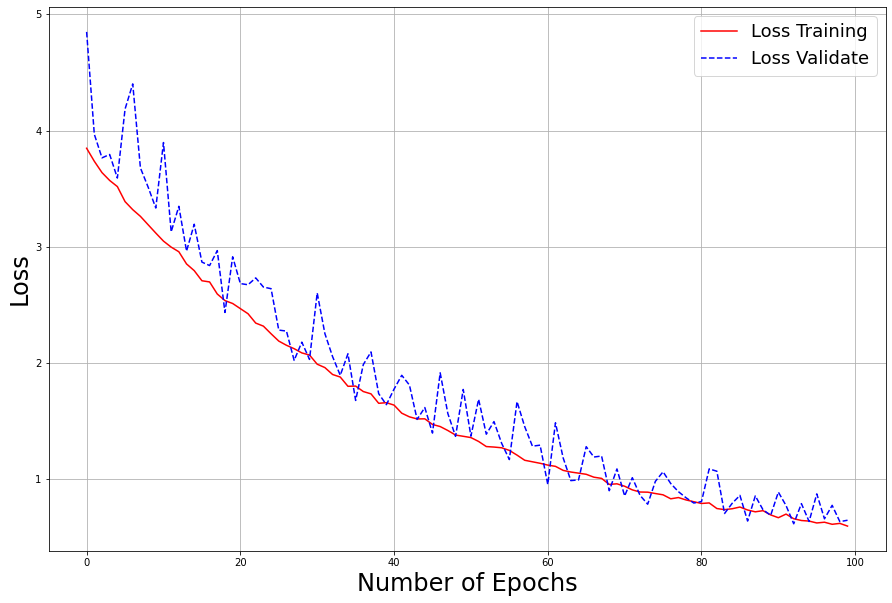

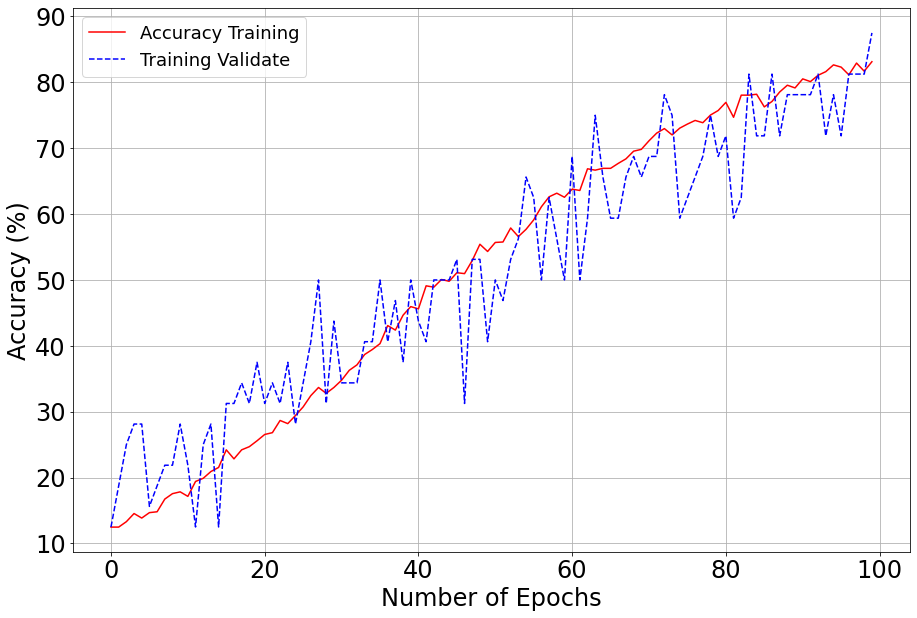

In [9]:
plotTraining(log_data,epochs,"loss")
plotTraining(log_data,epochs,"accuracy")
plotTraining(log_data,epochs,"val_loss")
plotTraining(log_data,epochs,"val_accuracy")

AMERICAN BITTERN


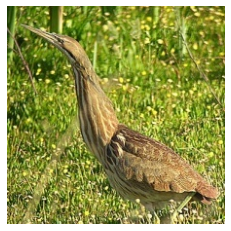

In [11]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']

imaget_path = "/Users/hahn/Documents/Python/RN_VGG/DataSet/Bird_Classifications/test/AMERICAN BITTERN/3.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Found 50 images belonging to 10 classes.
[0 0 8 0 0 1 1 1 5 1 2 2 2 2 2 3 3 5 3 3 4 8 4 4 0 5 5 5 5 5 6 6 6 3 3 4 7
 3 7 8 8 4 8 8 8 6 4 9 1 9]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]
              precision    recall  f1-score   support

           0        0.8       0.8       0.8         5
           1        0.8       0.8       0.8         5
           2        1.0       1.0       1.0         5
           3        0.6       0.8       0.7         5
           4        0.5       0.6       0.5         5
           5        0.7       1.0       0.8         5
           6        0.8       0.6       0.7         5
           7        1.0       0.4       0.6         5
           8        0.6       0.8       0.7         5
           9        1.0       0.4       0.6         5

    accuracy                            0.7        50
   macro avg        0.8       0.7       0.7        50
weighted avg        0.8       0.7       0.7      

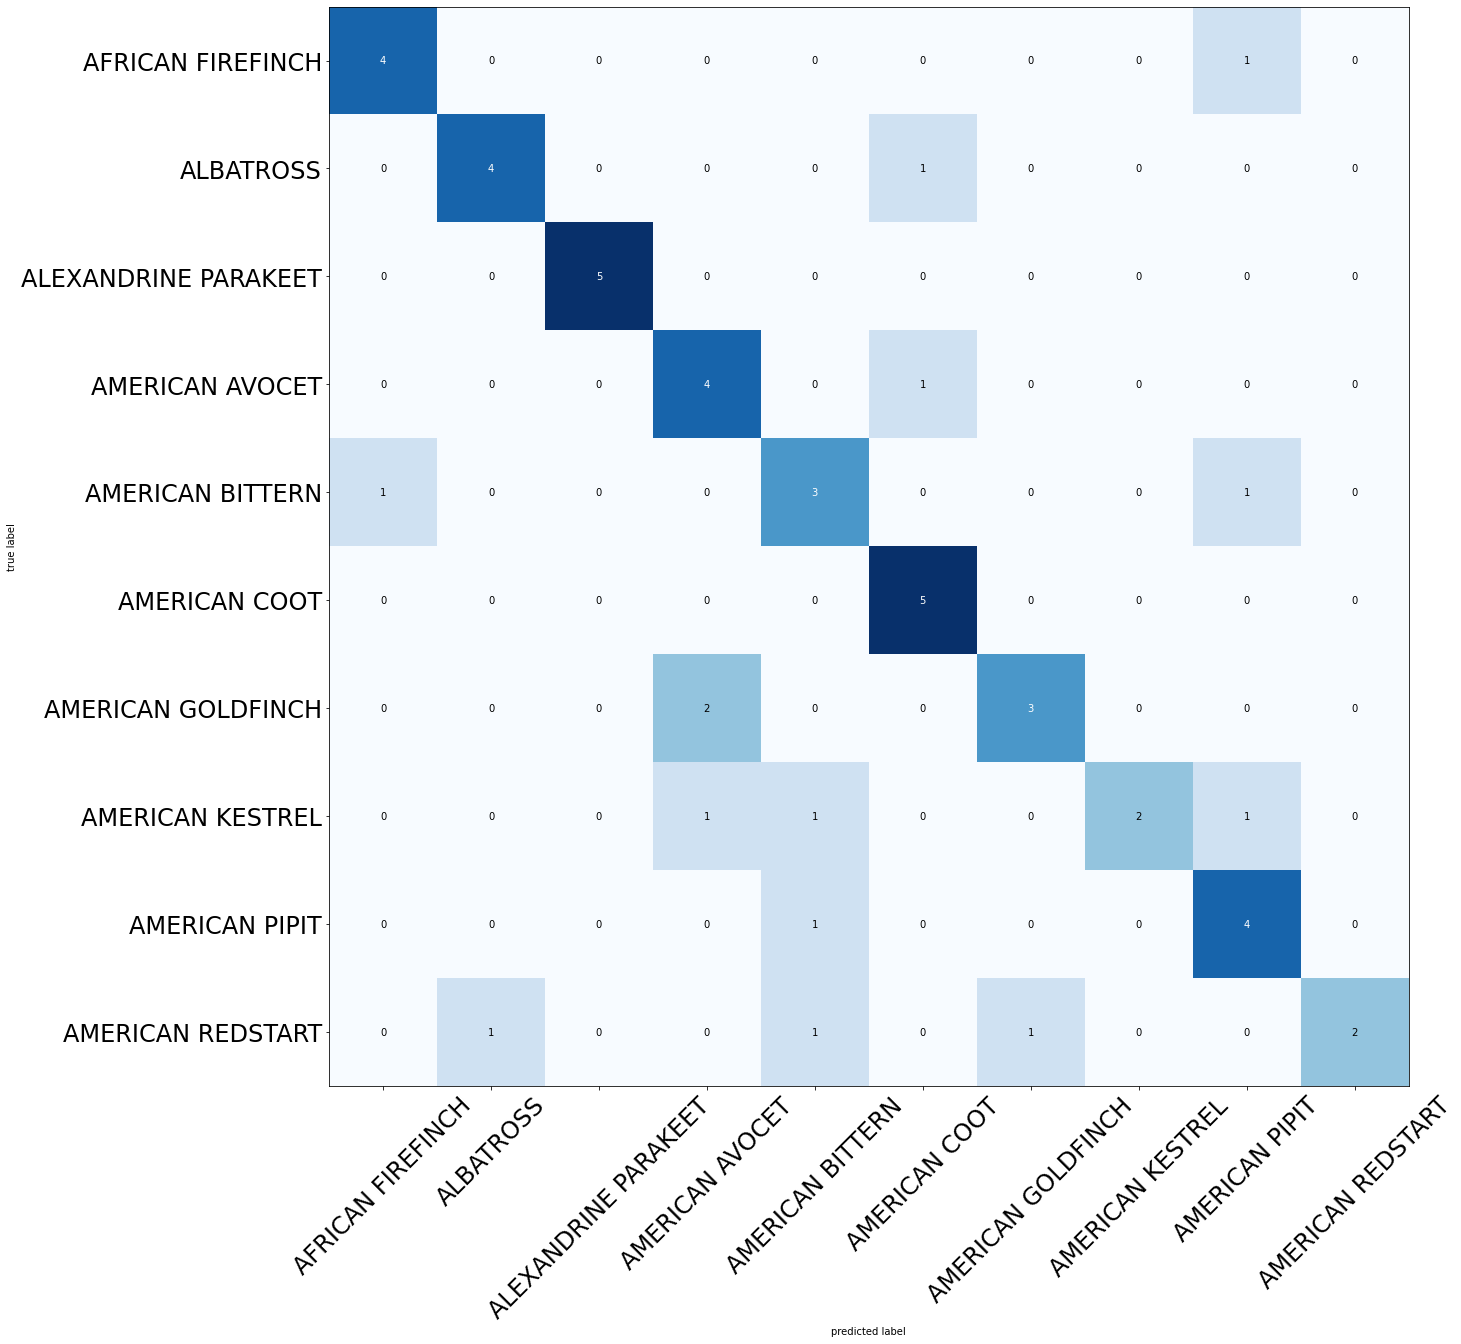

In [12]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']


test_data_dir = '/Users/hahn/Documents/Python/RN_VGG/DataSet/Bird_Classifications/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("{}.h5".format(output_name))

predictions = custom_Model.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)
print(y_pred)
y_real = test_generator.classes
print(y_real)


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(20,20), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 1))